In [1143]:
library('purrr')
library("rstan")
options(mc.cores = parallel::detectCores())

## Bernoulli

In order to have something to work with, we make up a small dataset. The usual datasets for classification are rather big and we will have trouble running the model in. This is the same dataset as in the analytical notebook using the custom classifier.

In [1144]:
X <- matrix(c(
  0, 0, 1, 1, 1,
  1, 0, 1, 1, 0,
  1, 1, 0, 0, 1,
  1, 1, 0, 0, 0,
  0, 1, 0, 0, 1,
  0, 0, 0, 1, 0,
  1, 0, 0, 1, 1,
  1, 1, 0, 0, 1,
  1, 1, 1, 1, 0,
  1, 1, 0, 1, 0,
  1, 1, 0, 1, 1,
  1, 0, 1, 1, 0,
  1, 0, 1, 0, 0
), nrow=13, byrow = TRUE)
y <- rep(c(0, 1), times=c(6, 7))

Fill in the data for the model:

In [1145]:
data <- list(
  C = 2,                                  # num categories
  K = dim(X)[2],                          # num features
  N = dim(X)[1],                          # num samples
  y = y + 1,                              # category of sample n
  x = X,                                  # sample n
  alpha = c(1, 1),                        # category prior
  beta = matrix(rep(2, times=10), nrow=2) # feature prior
)
fit <- stan(file = 'model_bernoulli.stan', iter = 20000, data = data, chains = 4)

Print the stats of the model

In [1146]:
print(fit)

Inference for Stan model: model_bernoulli.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
theta[1]   0.47    0.00 0.12   0.23   0.38   0.47   0.55   0.71 85642    1
theta[2]   0.53    0.00 0.12   0.29   0.45   0.53   0.62   0.77 85642    1
phi[1,1]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.79 85617    1
phi[1,2]   0.50    0.00 0.15   0.22   0.39   0.50   0.61   0.78 86038    1
phi[1,3]   0.40    0.00 0.15   0.14   0.29   0.39   0.50   0.70 85529    1
phi[1,4]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.78 89036    1
phi[1,5]   0.50    0.00 0.15   0.21   0.39   0.50   0.61   0.79 88234    1
phi[2,1]   0.82    0.00 0.11   0.55   0.75   0.84   0.90   0.98 81560    1
phi[2,2]   0.55    0.00 0.14   0.27   0.44   0.55   0.65   0.81 84870    1
phi[2,3]   0.45    0.00 0.14   0.18   0.35   0.45   0.55   0.74 89312    1
phi[2,4]  

Out of curiousness, we check the value of one of the parameters and find that it roughly follows a beta distribution

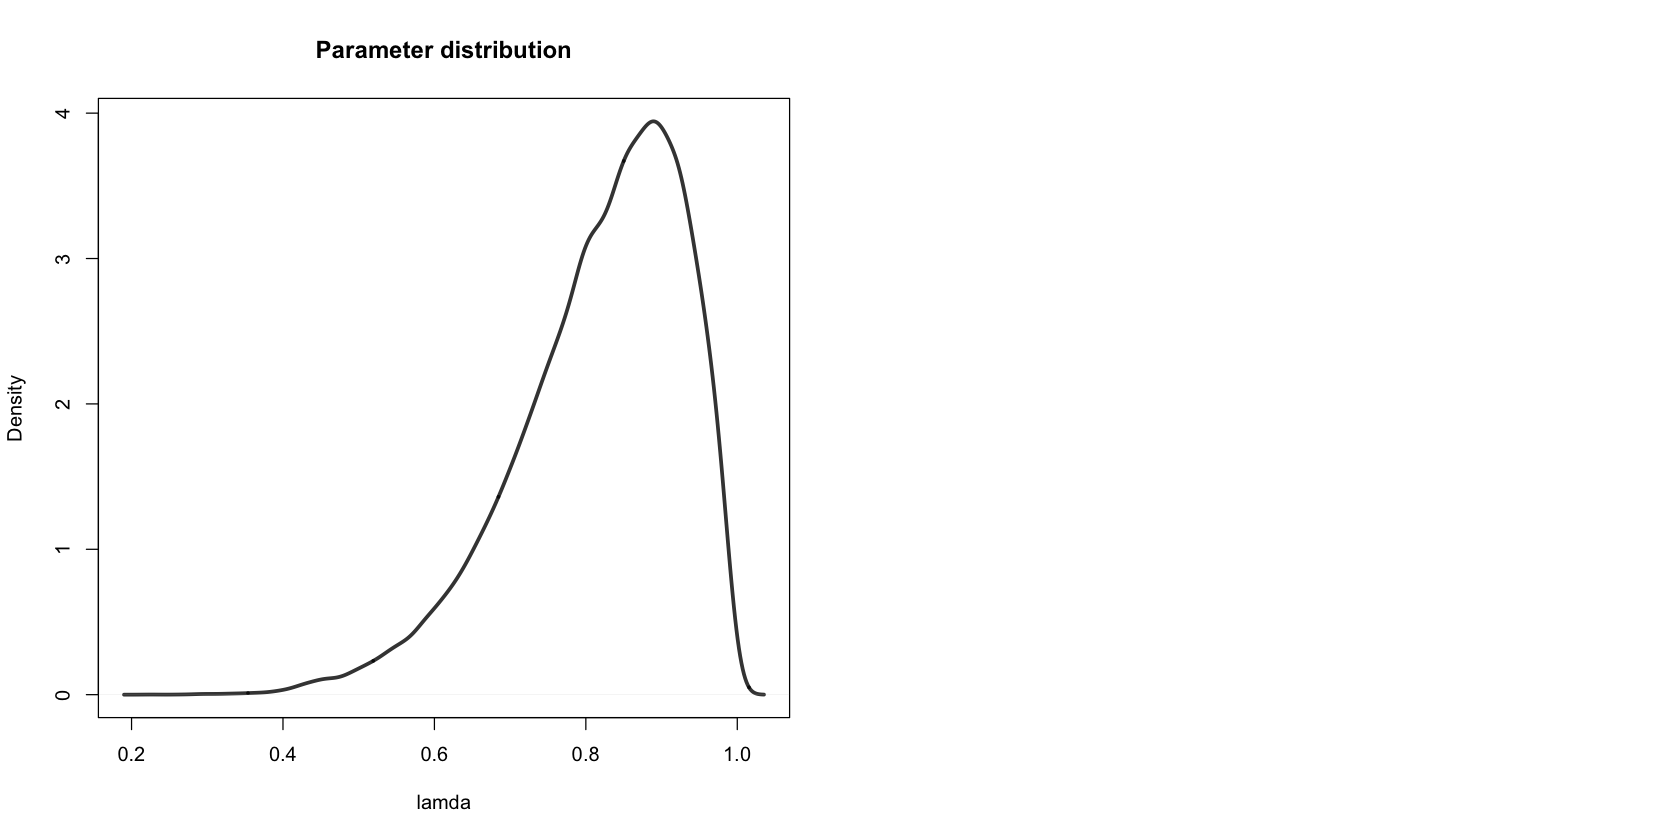

In [1147]:
phi <- unlist(extract(fit, 'phi[2,1]'), use.names = FALSE)
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))
plot(density(phi),
     xlab=expression(lamda), col=grey(0, 0.8),lwd=3,
     main="Parameter distribution")

Now we evaluate the same data sample as the analytical notebook and check its probabilities

In [1148]:
# retrieve the stan summary object
smry <- summary(fit)$summary

# retrieve our parameters from the summary
phis <- smry[grepl('phi',row.names(smry)),'mean']
thetas <- smry[grepl('theta',row.names(smry)),'mean'] %>% as.vector

# adjust the dimensions so that they are (features, classes)
dim(phis) <- c(data$K, data$C)

In [1149]:
# we take the same data sample as the Python notebook
x <- c(1,0,1,1,0)

# calculate the numerator in the final probabilities
proba <- (apply(phis, 2, function(p) p*x + (1-p)*(1-x)) * thetas) |>
  apply(2, prod)

# and divide by total sum
proba/sum(proba)

[1] 0.2719615 0.7280385

The probabilities are close to the prediction in the analytical notebook using the Bayesian model. The probabilities are skewed slightly more towards the center

## Gaussian

On to something more serious. We replicate the classification of the raisin dataset in Stan. To that end, we use a gaussian model. We have to center and scale the data so that we can rather safely assume that the means are sampled from the same centered normal prior.

In [1150]:
df <- read.csv('data/Raisin_Dataset.csv')
X <- df[-dim(df)[2]]
# convert the y-vector into numbers instead of strings
y <- map_int(df[['Class']], ~ match(.x, levels(factor(df[['Class']]))))

In [1151]:
# draw a number of random numbers to determine the indices that make up the train set
set.seed(42)
train_size <- floor(0.8 * nrow(df))
ix <- sample(seq_len(nrow(df)), size = train_size)

# use the indices the assign the train and test datasets
X_train <- X[ix,]
X_test <- X[-ix,]
y_train <- y[ix]
y_test <- y[-ix]

# we use scale both the train and test set according to the train set
means <- sapply(X_train, mean)
sds <- sapply(X_train, sd)
X_train <- X_train %>% map2_df(means, `-`) %>% map2_df(sds, `/`)
X_test <- X_test %>% map2_df(means, `-`) %>% map2_df(sds, `/`)

Because we don't have much prior knowledge, we choose rather flat priors. In fact, the choice of prior is not the focus of this project, so it does not matter much.

In [1152]:
data <- list(
  C = max(y),              # num categories
  K = ncol(X_train),       # num features
  N = nrow(X_train),       # num samples
  y = y_train,             # category of sample n
  x = X_train,             # sample n
  alpha = rep(1, max(y)),  # category prior
  mu_mu = 0,               # feature mean prior
  mu_sigma = 5,            # feature mean prior
  sigma_alpha = 1,         # feature sd prior
  sigma_beta = 1           # feature sd prior
)

fit <- stan(file = 'model_gaussian.stan', data = data, iter = 10000)

In [1153]:
print(fit)

Inference for Stan model: model_gaussian.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                       mean se_mean   sd     2.5%      25%      50%      75%
theta[1]               0.48    0.00 0.02     0.44     0.47     0.48     0.49
theta[2]               0.52    0.00 0.02     0.48     0.51     0.52     0.53
mu[1,1]                0.65    0.00 0.06     0.54     0.61     0.65     0.69
mu[1,2]                0.70    0.00 0.05     0.60     0.67     0.70     0.73
mu[1,3]                0.52    0.00 0.06     0.41     0.48     0.52     0.55
mu[1,4]                0.45    0.00 0.04     0.37     0.42     0.45     0.47
mu[1,5]                0.65    0.00 0.05     0.54     0.61     0.65     0.69
mu[1,6]               -0.15    0.00 0.06    -0.28    -0.19    -0.15    -0.11
mu[1,7]                0.69    0.00 0.05     0.60     0.66     0.69     0.73
mu[2,1]               -0.60    0.00 0.02    -0.65    -0.62    -0.60 

To do inference, we extract the parameters from the model

In [1154]:
# retrieve the stan summary object
smry <- summary(fit)$summary

# retrieve our parameters from the summary
mus <- smry[grepl('mu',row.names(smry)),'mean']
sigmas <- smry[grepl('sigma\\[',row.names(smry)),'mean']
thetas <- smry[grepl('theta',row.names(smry)),'mean'] %>% as.vector

# adjust the dimensions so that they are (features, classes)
dim(mus) <- c(data$K, data$C)
dim(sigmas) <- c(data$K, data$C)

Now we calculate the probabilities according to the distributions from the parameters and find the maximum probabilities to predict the class

In [1155]:
# make a prediction by looping over each individual sample
y_pred <- lapply(1:nrow(X_test), \(i) as.matrix(X_test[i,]) |>
  matrix(ncol=ncol(X)) |>                         # shape the sample so that it broadcasts correctly
  dnorm(mean = mus, sd = sigmas, log = TRUE) |>   # calculate the pd for the various features over all classes
  colSums() |>                                    # sum the pds
  (\(x) x + log(thetas))() |>                     # add class probabilities (sometimes refered to as priors)
  which.max()                                     # predict the class
)

The final accuracy:

In [1156]:
mean(y_pred==y_test)

[1] 0.8444444

This is slightly higher than the analytical model. The Bayesian approach appears to have combatted possible overfitting and other statistical irregularities. Of course, we cannot draw strong conclusions from this single number over a single test. We take a final look at the distribution of the means:

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



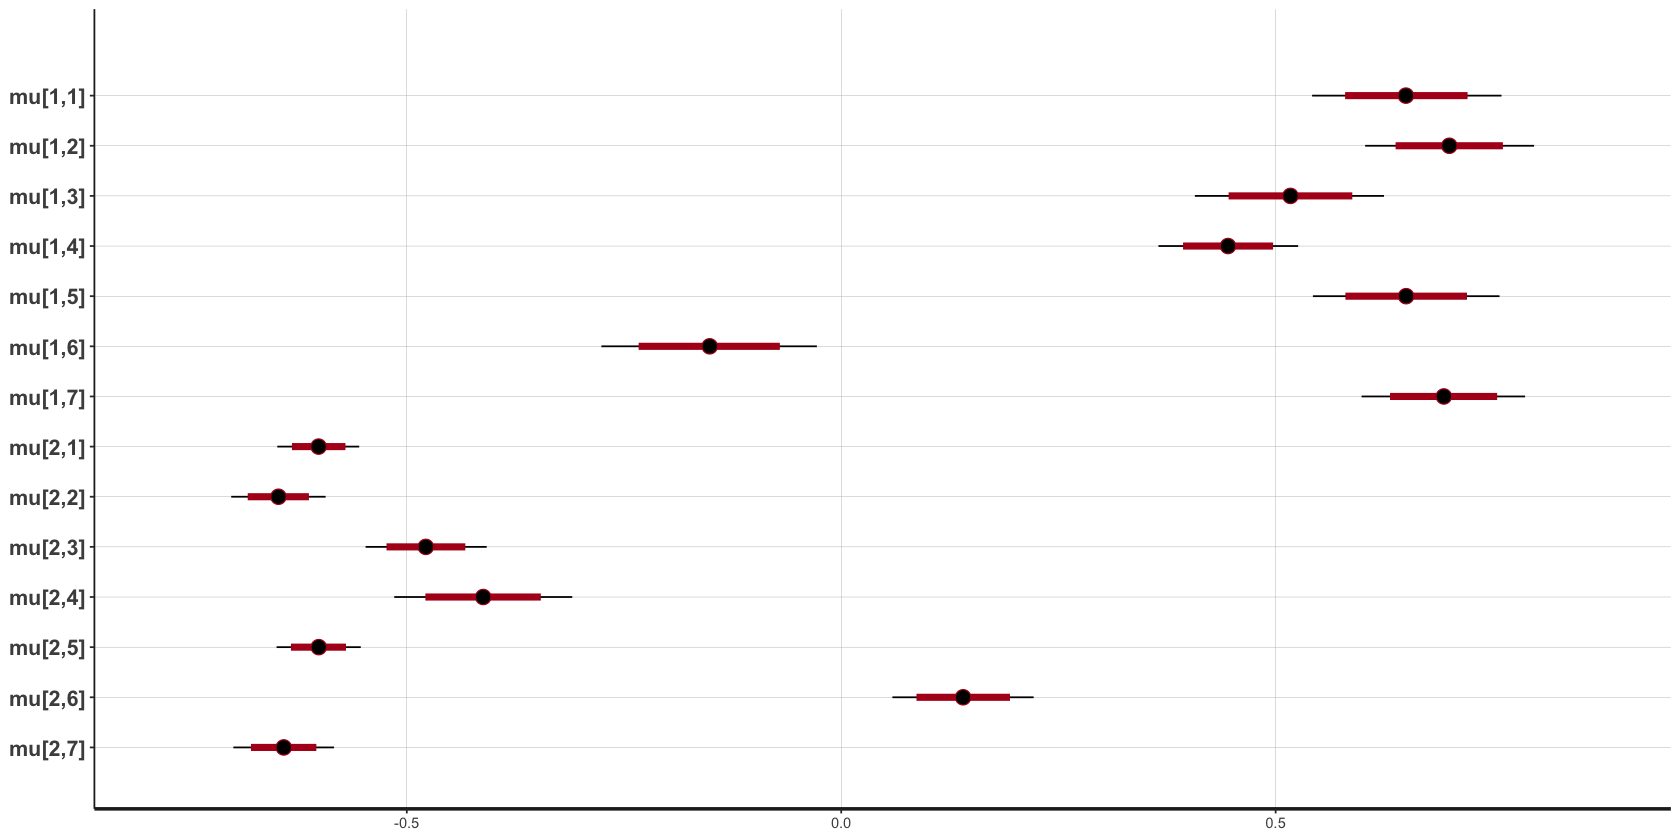

In [1157]:
stan_plot(fit, c('mu'))